In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# List all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-07-16 14:14:28.563851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752675268.762123      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752675268.826313      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/dataset/NTC_historical_data.csv
/kaggle/input/dataset/AHPC_historical_data.csv
/kaggle/input/dataset/NABIL_historical_data.csv
/kaggle/input/dataset/NICL_historical_data.csv
/kaggle/input/dataset/SHL_historical_data.csv


In [2]:
# Load all NEPSE datasets from the input directory
def load_kaggle_data():
    
    base_path = '/kaggle/input/dataset/'
    
    stocks = {
        'AHPC': pd.read_csv(base_path + 'AHPC_historical_data.csv'),
        'NABIL': pd.read_csv(base_path + 'NABIL_historical_data.csv'),
        'NICL': pd.read_csv(base_path + 'NICL_historical_data.csv'),
        'NTC': pd.read_csv(base_path + 'NTC_historical_data.csv'),
        'SHL': pd.read_csv(base_path + 'SHL_historical_data.csv')
    }
    return stocks

# Load the data
nepse_data = load_kaggle_data()

# verifying the dataset loaded
print(nepse_data['NABIL'].head())

         Date    Open    High     Low   Close  Adj Close  Volume
0  2010-07-19  803.81  814.24  788.87  794.25     794.85   20730
1  2010-07-20  779.75  808.61  765.70  796.85     796.21   75900
2  2010-07-21  820.82  833.62  785.67  791.06     789.61   43070
3  2010-07-22  798.55  810.27  784.83  791.20     792.08   14990
4  2010-07-23  792.60  800.38  780.94  793.68     793.99   60870


In [3]:
#data pre processing
def preprocess_data(df):
    # Convert date and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Create technical indicators
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # NEPSE-specific features
    df['Price_Change'] = df['Close'].diff()
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Intraday_Change'] = (df['Close'] - df['Open']) / df['Open']
    
    df.dropna(inplace=True)
    return df

# Preprocess all stocks
for symbol, data in nepse_data.items():
    nepse_data[symbol] = preprocess_data(data)

In [4]:
#training the model
def create_features(df):
    features = df[['Open', 'High', 'Low', 'Volume', 'MA20', 'MA50', 'Volatility', 
                  'Price_Change', 'Gap', 'Intraday_Change']]
    target = df['Close']
    return features, target

def train_models(X_train, y_train):
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Random Forest (reduced n_estimators for Kaggle)
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    rf_model.fit(X_scaled, y_train)
    
    # SVM (reduced complexity for Kaggle)
    svm_model = SVR(kernel='rbf', C=10, gamma='scale')
    svm_model.fit(X_scaled, y_train)
    
    # LSTM (simplified architecture)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_lstm, y_train, epochs=30, batch_size=32, verbose=1)
    
    return {
        'rf': rf_model,
        'svm': svm_model,
        'lstm': lstm_model,
        'scaler': scaler
    }

In [5]:
#monte carlo simulation (memory efficient)
def monte_carlo_simulation(df, n_simulations=50000, days=1800):
    """Reduced simulations and days for Kaggle memory constraints"""
    log_returns = np.log(1 + df['Daily_Return'].dropna())
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    last_price = df['Close'].iloc[-1]
    simulations = np.zeros((days, n_simulations))
    
    for i in range(n_simulations):
        daily_shocks = np.random.normal(mu, sigma, days)
        price_path = last_price * np.exp(np.cumsum(daily_shocks))
        simulations[:, i] = price_path
    
    return simulations


=== Processing AHPC ===
Training models...


I0000 00:00:1752675281.591326      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


I0000 00:00:1752675286.260159     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 175971.8750
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 174545.0625
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 167228.0781
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 162767.7188
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 160689.8438
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 159315.6719
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 156092.6406
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 153659.7344
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 151465.8438
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 149930.4688
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 148198.0312
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 146746.7656
Epoch 13/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 145041.8594
Epoch 14/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 142954.9844
Epoch 15/30
97/97 ━━━━━━━━

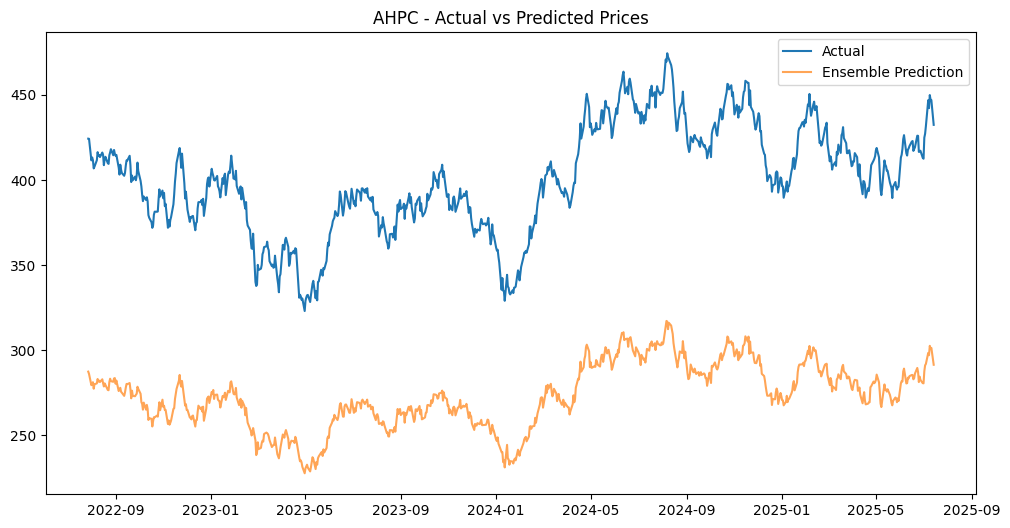


=== Processing NABIL ===
Training models...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 501751.1875
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 491669.8125
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 486940.6875
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 479013.7188
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 469910.5625
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 469394.0938
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 459873.2500
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 465697.2500
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 459919.8750
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 453854.6250
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 452668.8438
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 445150.9688
Epoch 13/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 443136.1562
Epoch 14/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 439236.8125
Epoch 15/30
97/97 ━━━━━━━━

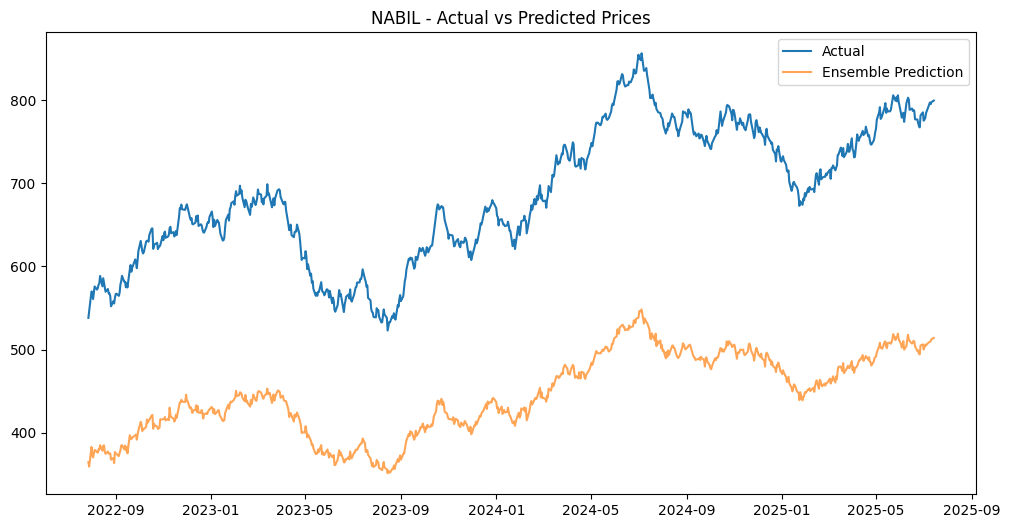


=== Processing NICL ===
Training models...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 557840.1250
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 547703.1875
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 539391.8125
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 529121.8750
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 526483.9375
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 519535.4688
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 510145.0312
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 511666.3125
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 506621.2812
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 498624.6875
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 494933.9375
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 491887.2188
Epoch 13/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 486468.6875
Epoch 14/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 484779.1875
Epoch 15/30
97/97 ━━━━━━━━

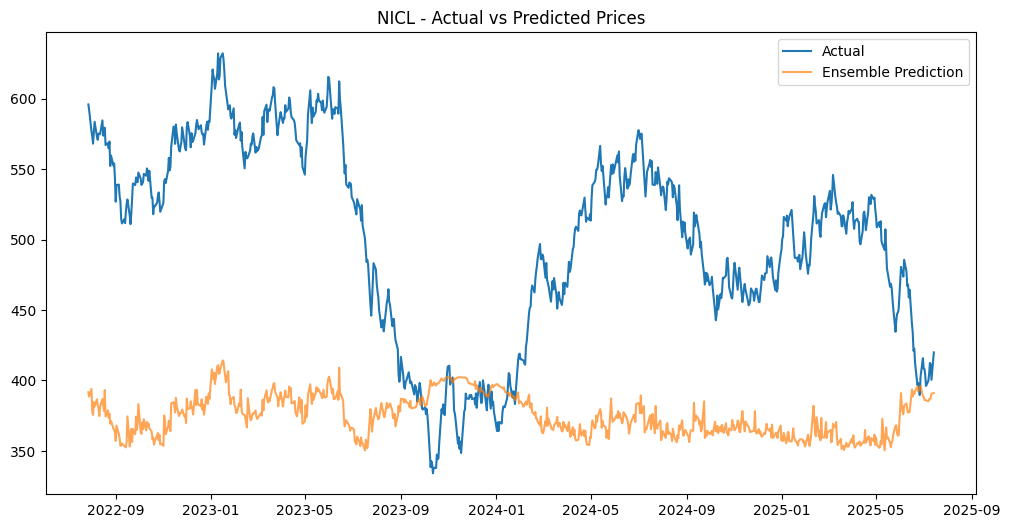


=== Processing NTC ===
Training models...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 494589.0938
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 488677.7500
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 475063.3750
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 474366.1875
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 463921.1562
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 463812.6875
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 458897.5625
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 459951.4375
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 455705.1250
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 447149.9062
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 450239.6250
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 441266.8438
Epoch 13/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 440015.8125
Epoch 14/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 427492.7812
Epoch 15/30
97/97 ━━━━━━━━

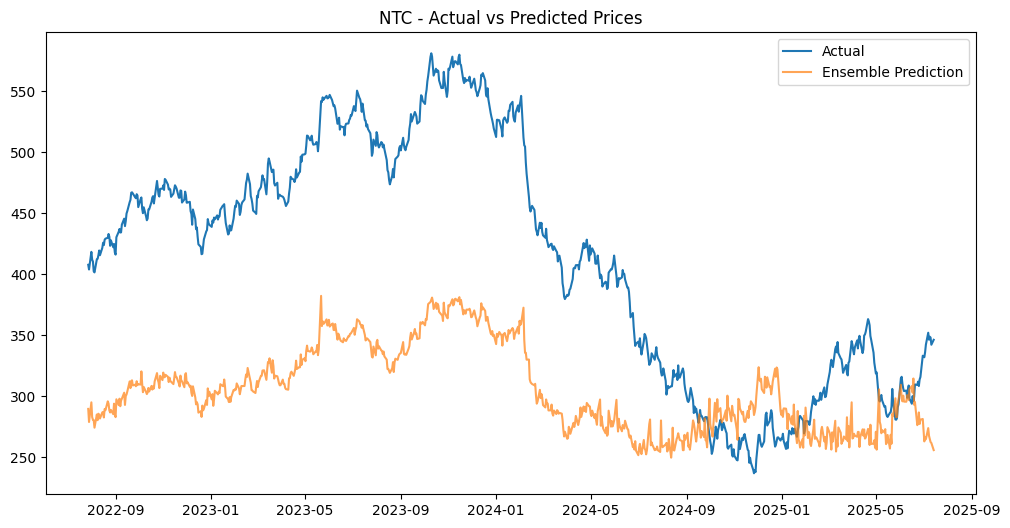


=== Processing SHL ===
Training models...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 179421.1094
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 176338.2969
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 172598.0625
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 167088.7031
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164330.7656
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 160959.5781
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 159540.4219
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 157696.2969
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 154907.4062
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 155362.9688
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 155491.8438
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 148640.7812
Epoch 13/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 146940.3906
Epoch 14/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 143324.8125
Epoch 15/30
97/97 ━━━━━━━━

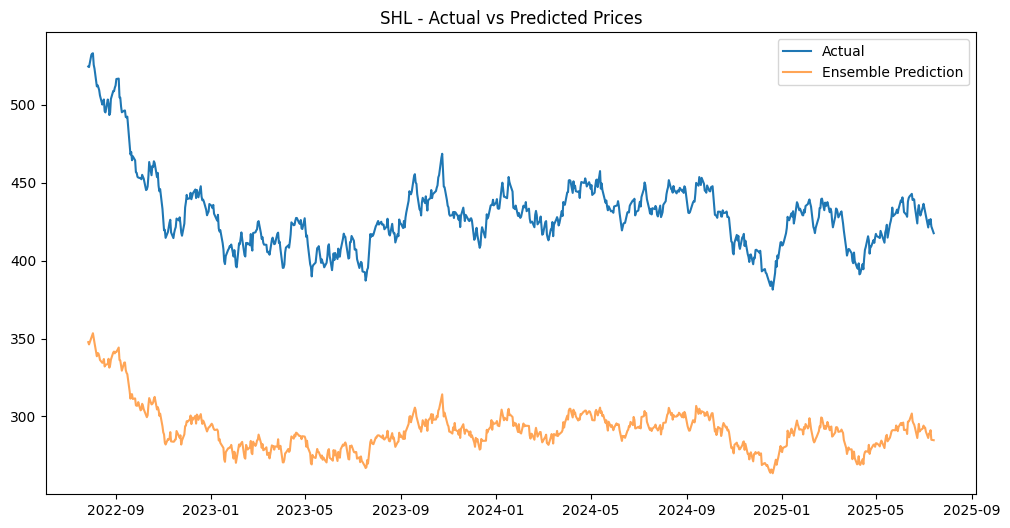

In [6]:
#main execution pipeline
results = {}

for symbol, data in nepse_data.items():
    print(f"\n=== Processing {symbol} ===")
    
    # Create features and split data
    features, target = create_features(data)
    split_idx = int(len(features) * 0.8)
    X_train, X_test = features.iloc[:split_idx], features.iloc[split_idx:]
    y_train, y_test = target.iloc[:split_idx], target.iloc[split_idx:]
    
    # Train models
    print("Training models...")
    models = train_models(X_train, y_train)
    
    # Make predictions
    X_test_scaled = models['scaler'].transform(X_test)
    rf_pred = models['rf'].predict(X_test_scaled)
    svm_pred = models['svm'].predict(X_test_scaled)
    lstm_pred = models['lstm'].predict(
        X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))).flatten()
    
    # Ensemble prediction (weighted average)
    ensemble_pred = 0.4*lstm_pred + 0.35*rf_pred + 0.25*svm_pred
    mse = mean_squared_error(y_test, ensemble_pred)
    print(f"Ensemble MSE: {mse:.4f}")
    
    # Monte Carlo Simulation
    print("Running Monte Carlo simulations...")
    simulations = monte_carlo_simulation(data)
    
    # Store results
    results[symbol] = {
        'models': models,
        'test_predictions': ensemble_pred,
        'test_actual': y_test,
        'simulations': simulations
    }
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, ensemble_pred, label='Ensemble Prediction', alpha=0.7)
    plt.title(f'{symbol} - Actual vs Predicted Prices')
    plt.legend()
    plt.show()

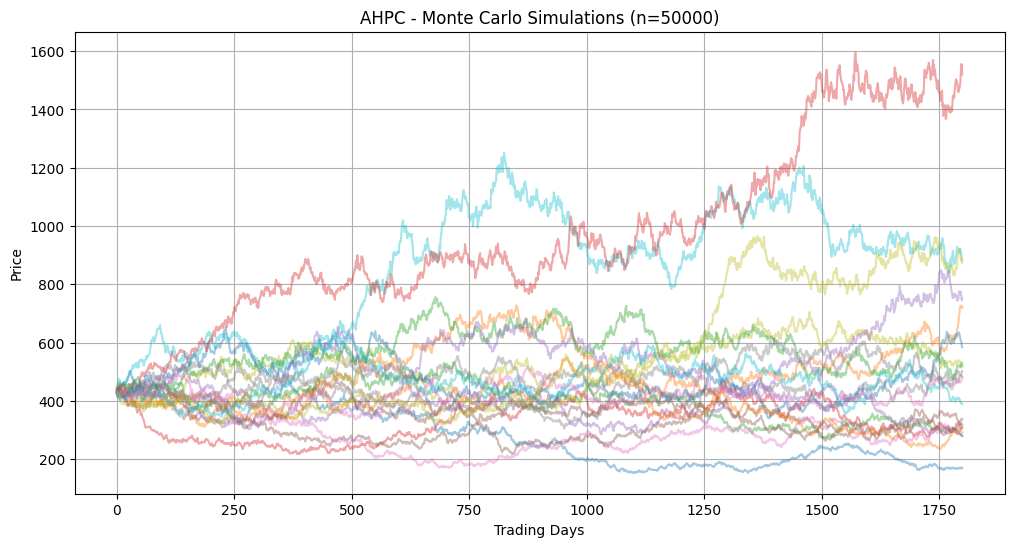


AHPC Risk Analysis:
- Average Return: 29.43%
- Best Case: 982.15%
- Worst Case: -87.77%
- 95% VaR: -56.19%
- 95% CVaR: -64.71%


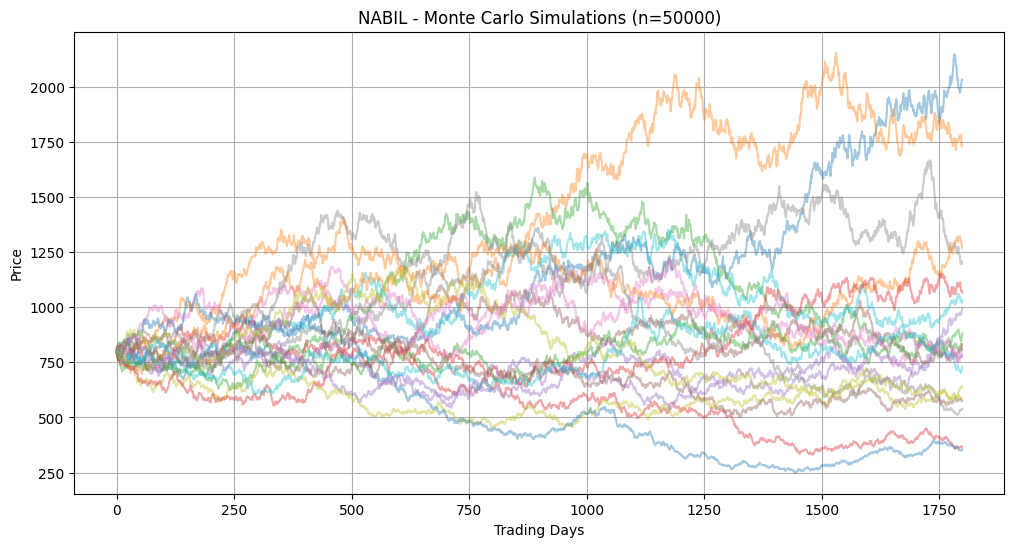


NABIL Risk Analysis:
- Average Return: 11.33%
- Best Case: 677.62%
- Worst Case: -84.97%
- 95% VaR: -53.21%
- 95% CVaR: -60.76%


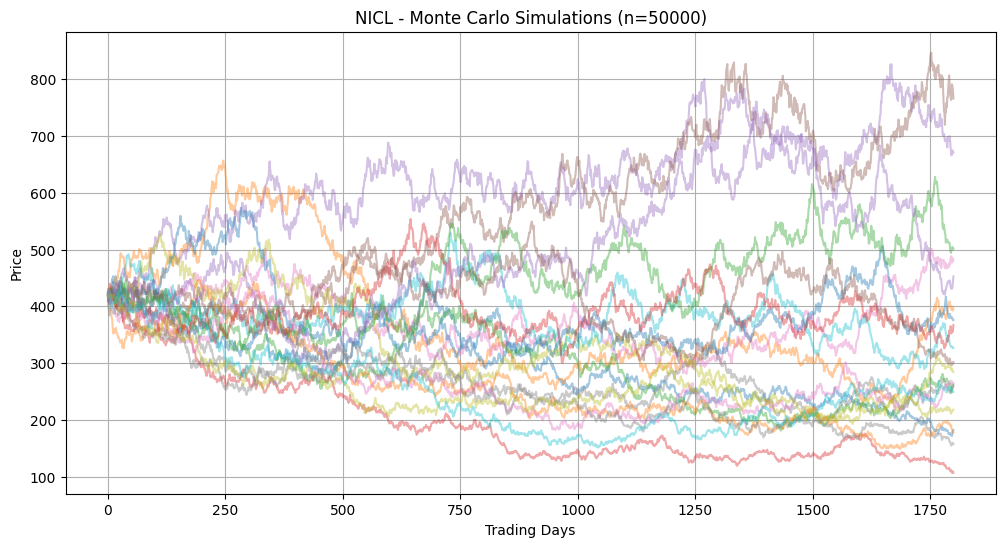


NICL Risk Analysis:
- Average Return: 1.29%
- Best Case: 727.69%
- Worst Case: -89.70%
- 95% VaR: -65.73%
- 95% CVaR: -72.27%


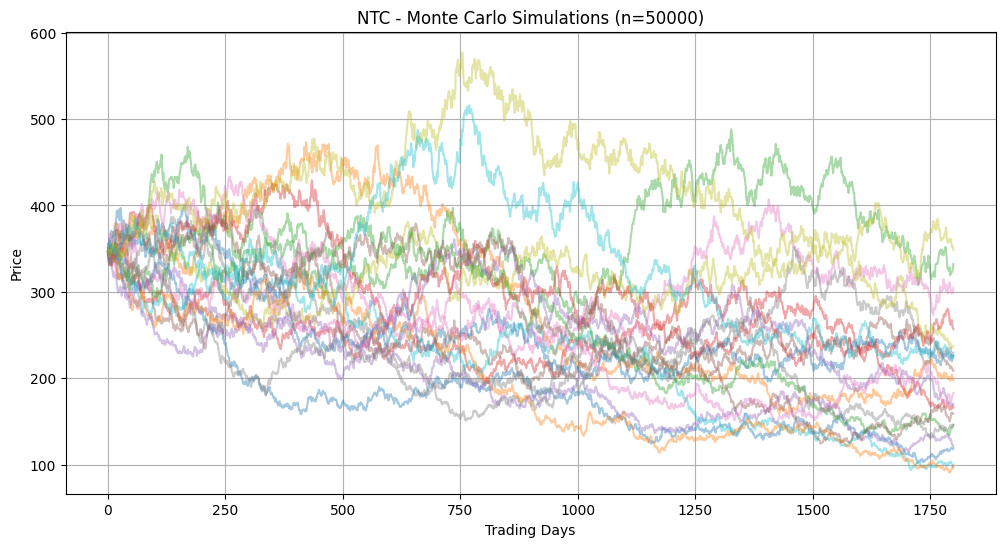


NTC Risk Analysis:
- Average Return: -29.45%
- Best Case: 357.61%
- Worst Case: -91.79%
- 95% VaR: -73.25%
- 95% CVaR: -77.99%


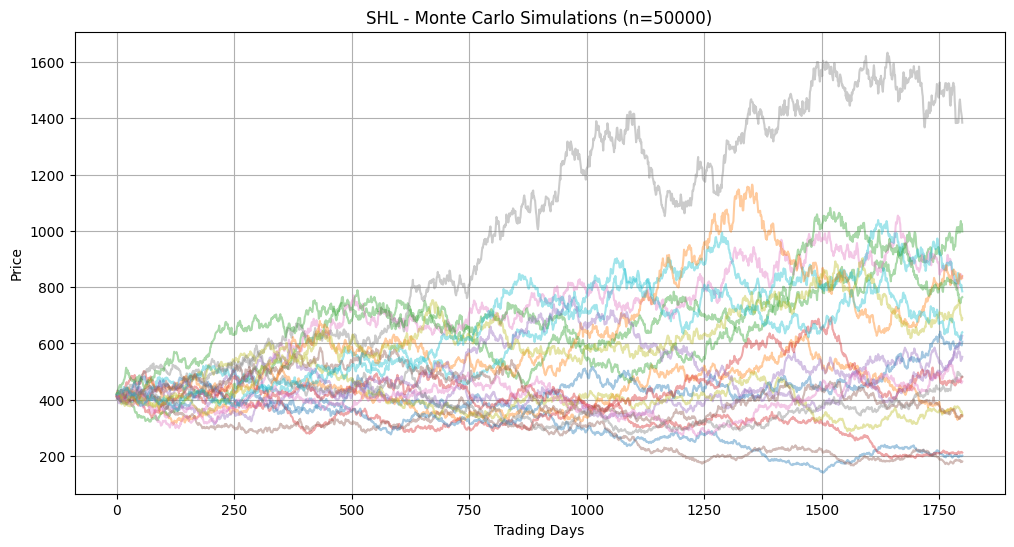


SHL Risk Analysis:
- Average Return: 9.33%
- Best Case: 759.11%
- Worst Case: -87.78%
- 95% VaR: -60.96%
- 95% CVaR: -68.25%


In [7]:
#visualization and analysis
def plot_simulations(symbol, simulations, n_to_plot=20):
    plt.figure(figsize=(12, 6))
    for i in range(min(n_to_plot, simulations.shape[1])):
        plt.plot(simulations[:, i], alpha=0.4)
    
    plt.title(f'{symbol} - Monte Carlo Simulations (n={simulations.shape[1]})')
    plt.xlabel('Trading Days')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

# Plot simulations and calculate risk metrics
for symbol, result in results.items():
    plot_simulations(symbol, result['simulations'])
    
    # Calculate risk metrics
    final_prices = result['simulations'][-1, :]
    initial_price = result['simulations'][0, 0]
    returns = (final_prices - initial_price) / initial_price * 100
    
    print(f"\n{symbol} Risk Analysis:")
    print(f"- Average Return: {returns.mean():.2f}%")
    print(f"- Best Case: {returns.max():.2f}%")
    print(f"- Worst Case: {returns.min():.2f}%")
    print(f"- 95% VaR: {np.percentile(returns, 5):.2f}%")
    print(f"- 95% CVaR: {returns[returns <= np.percentile(returns, 5)].mean():.2f}%")
    
    # Save simulation results to CSV
    sim_df = pd.DataFrame(result['simulations'])
    sim_df.to_csv(f'/kaggle/working/{symbol}_simulations.csv', index=False)